### Inline Bayesian Linear Regression

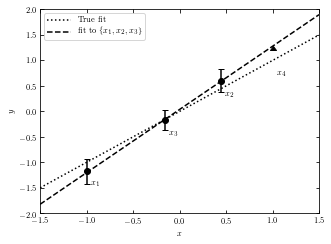

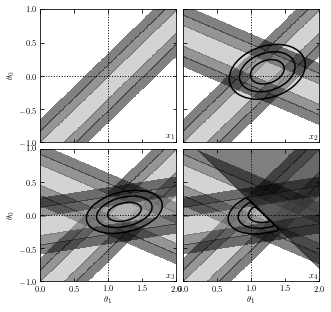

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Set up the data and errors
np.random.seed(13)
a = 1
b = 0

x = np.array([-1, 0.44, -0.16])
y = a * x + b
dy = np.array([0.25, 0.22, 0.2])

y = np.random.normal(y, dy)

# add a fourth point which is a lower bound
x4 = 1.0
y4 = a * x4 + b + 0.2

# compute the likelihoods for each point
a_range = np.linspace(0, 2, 80)
b_range = np.linspace(-1, 1, 80)
logL = -((a_range[:, None, None] * x + b_range[None, :, None] - y)/dy)**2
sigma = [convert_to_stdev(logL[:, :, i]) for i in range(3)]

# Compute best-fit from first three points
logL_together = logL.sum(-1)
i, j = np.where(logL_together == np.max(logL_together))
amax = a_range[i[0]]
bmax = b_range[j[0]]

# Compute the first figure: the points and errorbars
fig1 = plt.figure(figsize=(5, 3.75))
ax1 = fig1.add_subplot(111)

# Draw the true and best-fit lines
xfit = np.array([-1.5, 1.5])
ax1.plot(xfit, a * xfit + b, ':k', label='True fit')
ax1.plot(xfit, amax * xfit + bmax, '--k', label='fit to $\{x_1, x_2, x_3\}$')

ax1.legend(loc=2)

ax1.errorbar(x, y, dy, fmt='ok')
ax1.errorbar([x4], [y4], [[0.5], [0]], fmt='_k', lolims=True)

for i in range(3):
    ax1.text(x[i] + 0.05, y[i] - 0.3, "$x_{%i}$" % (i + 1))
ax1.text(x4 + 0.05, y4 - 0.5, "$x_4$")

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-2, 2)

# Plot the second figure: LIkelihoods for each point
fig2 = plt.figure(figsize=(5, 5))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)

# plot likelihood contours
for i in range(4):
    ax = fig2.add_subplot(221 + i)
    for j in range(min(i + 1, 3)):
        ax.contourf(a_range, b_range, sigma[j].T,
                   levels = (0, 0.683, 0.955, 0.997),
                    cmap = plt.cm.binary, alpha = 0.5)
        
        
# plot the excluded area from the fourth point
axpb = a_range[:, None] * x4 + b_range[None, :]
mask = y4 < axpb
fig2.axes[3].fill_between(a_range, y4 - x4 * a_range, 2, color='k', alpha=0.5)

# # plot ellipses
for i in range(1, 4):
    ax = fig2.axes[i]
    logL_together = logL[:, :, :i + 1].sum(-1)
    if i == 3:
        logL_together[mask] = -np.inf

    sigma_together = convert_to_stdev(logL_together)

    ax.contour(a_range, b_range, sigma_together.T,
               levels=(0.683, 0.955, 0.997),
               colors='k')
    


# Label and adjust axes
for i in range(4):
    ax = fig2.axes[i]

    ax.text(1.98, -0.98, "$x_{%i}$" % (i + 1), ha='right', va='bottom')

    ax.plot([0, 2], [0, 0], ':k', lw=1)
    ax.plot([1, 1], [-1, 1], ':k', lw=1)

    ax.set_xlim(0.001, 2)
    ax.set_ylim(-0.999, 1)

    if i in (1, 3):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 1):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 2):
        ax.set_ylabel(r'$\theta_0$')
    if i in (2, 3):
        ax.set_xlabel(r'$\theta_1$')


plt.show()


### Cosmology Regression Example

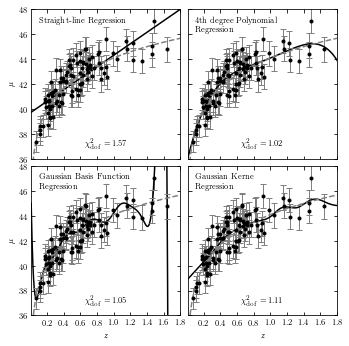

In [8]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.cosmology import LambdaCDM
from astroML.datasets import generate_mu_z
from astroML.linear_model import (LinearRegression, PolynomialRegression,
                                  BasisFunctionRegression, NadarayaWatson)


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state = 0)

cosmo = LambdaCDM(H0 = 70 , Om0 = 0.30, Ode0= 0.70, Tcmb0 = 0)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

# Define our classifiers
basis_mu = np.linspace(0, 2, 15)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

subplots = [221, 222, 223, 224]
classifiers = [LinearRegression(),
              PolynomialRegression(4),
              BasisFunctionRegression('gaussian',
                                     mu=basis_mu, sigma=basis_sigma),
              NadarayaWatson('gaussian', h=0.1)]

text = ['Straight-line Regression',
       '4th degree Polynomial\n Regression',
       'Gaussian Basis Function\n Regression',
       'Gaussian Kerne\n Regression']

# number of constraints of the model
n_constraints = [2, 5, len(basis_mu) + 1, 1]

# Plot the results
fig = plt.figure(figsize = (5, 5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)

for i in range(4):
    ax = fig.add_subplot(subplots[i])

    # fit the data
    clf = classifiers[i]
    clf.fit(z_sample[:, None], mu_sample, dmu)

    mu_sample_fit = clf.predict(z_sample[:, None])
    mu_fit = clf.predict(z[:, None])

    chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2)
                / (len(mu_sample) - n_constraints[i]))

    ax.plot(z, mu_fit, '-k')
    ax.plot(z, mu_true, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

    ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
            ha='center', va='bottom', transform=ax.transAxes)

    ax.set_xlim(0.01, 1.8)
    ax.set_ylim(36.01, 48)
    ax.text(0.05, 0.95, text[i], ha='left', va='top',
            transform=ax.transAxes)

    if i in (0, 2):
        ax.set_ylabel(r'$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if i in (2, 3):
        ax.set_xlabel(r'$z$')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

plt.show()


### Ridge and Lasso: Geometric Interpretation

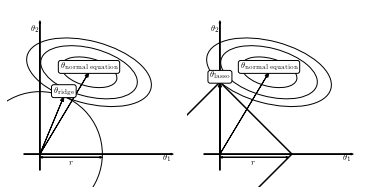

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse, Circle, RegularPolygon

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
    
# Set up figure
fig = plt.figure(figsize=(5, 2.5), facecolor = 'w')

# plot ridge diagram
ax = fig.add_axes([0, 0, 0.5, 1], frameon = False, xticks=[], yticks=[])

# plot the axes
ax.arrow(-1, 0, 9, 0, head_width = 0.1, fc='k')
ax.arrow(0, -1, 0, 9, head_width=0.1, fc='k')

# plot the ellipses and circles
for i in range(3):
    ax.add_patch(Ellipse((3, 5),
                        3.5 * np.sqrt(2 * i + 1), 1.7 * np.sqrt(2 * i + 1),
                        -15, fc = 'none'))

ax.add_patch(Circle((0, 0), 3.815, fc = 'none'))

# plot arrows
ax.arrow(0, 0, 1.46, 3.52, head_width = 0.2, fc = 'k',
        length_includes_head = True)
ax.arrow(0, 0, 3, 5, head_width=0.2, fc='k',
         length_includes_head=True)
ax.arrow(0, -0.2, 3.81, 0, head_width=0.1, fc='k',
         length_includes_head=True)
ax.arrow(3.81, -0.2, -3.81, 0, head_width=0.1, fc='k',
         length_includes_head=True)

# annotate with text
ax.text(7.5, -0.1, r'$\theta_1$', va='top')
ax.text(-0.1, 7.5, r'$\theta_2$', ha='right')
ax.text(3, 5 + 0.2, r'$\rm \theta_{normal\ equation}$',
        ha='center', bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(1.46, 3.52 + 0.2, r'$\rm \theta_{ridge}$', ha='center',
        bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(1.9, -0.3, r'$r$', ha='center', va='top')

ax.set_xlim(-2, 9)
ax.set_ylim(-2, 9)


# plot lasso diagram
ax = fig.add_axes([0.5, 0, 0.5, 1], frameon=False, xticks=[], yticks=[])

# plot axes
ax.arrow(-1, 0, 9, 0, head_width=0.1, fc='k')
ax.arrow(0, -1, 0, 9, head_width=0.1, fc='k')

# plot ellipses and circles
for i in range(3):
    ax.add_patch(Ellipse((3, 5),
                         3.5 * np.sqrt(2 * i + 1), 1.7 * np.sqrt(2 * i + 1),
                         -15, fc='none'))

# this is producing some weird results on save
#ax.add_patch(RegularPolygon((0, 0), 4, 4.4, np.pi, fc='none'))
ax.plot([-4.4, 0, 4.4, 0, -4.4], [0, 4.4, 0, -4.4, 0], '-k')

# plot arrows
ax.arrow(0, 0, 0, 4.4, head_width=0.2, fc='k', length_includes_head=True)
ax.arrow(0, 0, 3, 5, head_width=0.2, fc='k', length_includes_head=True)
ax.arrow(0, -0.2, 4.2, 0, head_width=0.1, fc='k', length_includes_head=True)
ax.arrow(4.2, -0.2, -4.2, 0, head_width=0.1, fc='k', length_includes_head=True)

# annotate plot
ax.text(7.5, -0.1, r'$\theta_1$', va='top')
ax.text(-0.1, 7.5, r'$\theta_2$', ha='right')
ax.text(3, 5 + 0.2, r'$\rm \theta_{normal\ equation}$',
        ha='center', bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(0, 4.4 + 0.2, r'$\rm \theta_{lasso}$', ha='center',
        bbox=dict(boxstyle='round', ec='k', fc='w'))
ax.text(2, -0.3, r'$r$', ha='center', va='top')

ax.set_xlim(-2, 9)
ax.set_ylim(-2, 9)

plt.show()


### Regularized Regression Example

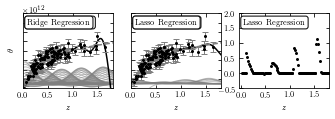

In [12]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.cosmology import LambdaCDM

from astroML.linear_model import LinearRegression
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Generate Data
np.random.seed(0)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = LambdaCDM(H0=70, Om0=0.30, Ode0=0.70, Tcmb0=0)

z = np.linspace(0.01, 2, 1000)
mu = cosmo.distmod(z).value

# Manually convert data to a gaussian basis
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

# Set up the figure to plot the results
fig = plt.figure(figsize = (5, 2.7))
fig.subplots_adjust(left = 0.1, right = 0.95,
                   bottom=0.12, top=0.95,
                    hspace=0.15, wspace=0.2)

regularization = ['none', 'l2', 'l1']
kwargs = [dict(), dict(alpha=0.005), dict(alpha=0.001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

for i in range(3):
    clf = LinearRegression(regularization = regularization[i],
                          fit_intercept = True, kwds = kwargs[i])
    clf.fit(X, mu_sample, dmu)
    w = clf.coef_[1:]
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))
    
    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

### Nonlinear cosmology fi tto mu vs z

@pickle_results: computing results and saving to 'mu_z_nonlinear.pkl'


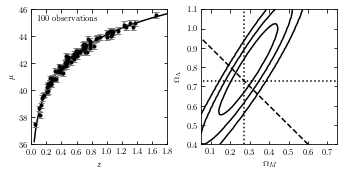

In [14]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astropy.cosmology import LambdaCDM

from astroML.datasets import generate_mu_z
from astroML.plotting.mcmc import convert_to_stdev
from astroML.utils.decorators import pickle_results


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


# Generate the data
z_sample, mu_sample, dmu = generate_mu_z(100, z0=0.3,
                                        dmu_0 = 0.05, dmu_1 = 0.004, 
                                        random_state = 1)

# define a log likelihood in terms of the parameters
# beta = [omegaM, omegaL]
def compute_logL(beta):
    cosmo = LambdaCDM(H0=71, Om0=beta[0], Ode0=beta[1], Tcmb0=0)
    mu_pred = cosmo.distmod(z_sample).value
    return - np.sum(0.5 * ((mu_sample - mu_pred) / dmu) ** 2)


# Define a function to compute (and save to file) the log-likelihood
@pickle_results('mu_z_nonlinear.pkl')
def compute_mu_z_nonlinear(Nbins = 50):
    omegaM = np.linspace(0.05, 0.75, Nbins)
    omegaL = np.linspace(0.4, 1.1, Nbins)
    
    logL = np.empty((Nbins, Nbins))
    
    for i in range(len(omegaM)):
        for j in range(len(omegaL)):
            logL[i, j] = compute_logL([omegaM[i], omegaL[j]])
            
    return omegaM, omegaL, logL

omegaM, omegaL, res = compute_mu_z_nonlinear()
res -= np.max(res)

# Plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

# left plot: the data and best-fit
ax = fig.add_subplot(121)
whr = np.where(res == np.max(res))
omegaM_best = omegaM[whr[0][0]]
omegaL_best = omegaL[whr[1][0]]
cosmo = LambdaCDM(H0=71, Om0=omegaM_best, Ode0=omegaL_best, Tcmb0=0)

z_fit = np.linspace(0.04, 2, 100)
mu_fit = cosmo.distmod(z_fit).value

ax.plot(z_fit, mu_fit, '-k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray')

ax.set_xlim(0, 1.8)
ax.set_ylim(36, 46)

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.text(0.04, 0.96, "%i observations" % len(z_sample),
        ha='left', va='top', transform=ax.transAxes)

# right plot: the likelihood
ax = fig.add_subplot(122)

ax.contour(omegaM, omegaL, convert_to_stdev(res.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')

ax.plot([0, 1], [1, 0], '--k')
ax.plot([0, 1], [0.73, 0.73], ':k')
ax.plot([0.27, 0.27], [0, 2], ':k')

ax.set_xlim(0.05, 0.75)
ax.set_ylim(0.4, 1.1)

ax.set_xlabel(r'$\Omega_M$')
ax.set_ylabel(r'$\Omega_\Lambda$')

plt.show()


### Total Least Square Fitting

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164


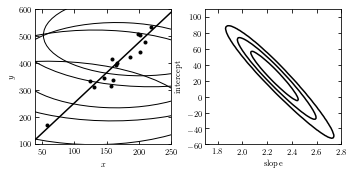

In [17]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Define some convenience functions
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b

def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])

# compute the ellipse principal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y
    
    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                            (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2) ** 2 + sigma_xy2 ** 2
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha
    
# Plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax = None):
    if ax is None:
        ax = plt.gca()
        
    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)
    
    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))


# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]   # no outliers
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func, 
                        x0=[-1, 1])

# Plot the data and fits
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

#------------------------------------------------------------
# first let's visualize the data
ax = fig.add_subplot(121)
ax.scatter(x, y, c='k', s=9)
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)

#------------------------------------------------------------
# plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit)
x_fit = np.linspace(0, 300, 10)
ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')

ax.set_xlim(40, 250)
ax.set_ylim(100, 600)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

#------------------------------------------------------------
# plot the likelihood contour in m, b
ax = fig.add_subplot(122)
m = np.linspace(1.7, 2.8, 100)
b = np.linspace(-60, 110, 100)
logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors='k')
ax.set_xlabel('slope')
ax.set_ylabel('intercept')
ax.set_xlim(1.7, 2.8)
ax.set_ylim(-60, 110)

plt.show()

### Huber Loss Function

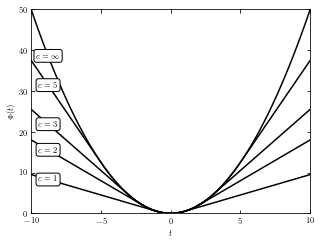

In [22]:
import numpy as np
from matplotlib import pyplot as plt

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


# Define the Huber loss
def Phi(t, c):
    t = abs(t)
    flag = (t > c)
    return (~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t)

# Plot for several values of c
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

x = np.linspace(-10, 10, 100)

for c in (1, 2, 3, 5, 1000):
    y = Phi(x, c)
    ax.plot(x, y, '-k')
    
    if c > 10:
        s = r'\infty'
    else:
        s = str(c)
        
    ax.text(x[6], y[6], '$c=%s$' % s,
           ha = 'center', va='center',
           bbox = dict(boxstyle='round', ec='k', fc='w'))
    
ax.set_xlabel('$t$')
ax.set_ylabel(r'$\Phi(t)$')

plt.show()

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 62
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 43.439758
         Iterations: 59
         Function evaluations: 115
[  1.07674745 213.27350923]
[ 1.96473118 70.00573832]


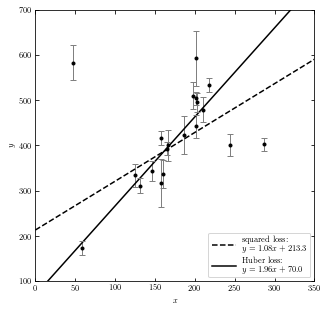

In [2]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize
from astroML.datasets import fetch_hogg2010test

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

# Define the standard squared-loss function
def squared_loss(m, b, x, y, dy):
    y_fit = m * x + b
    return np.sum(((y - y_fit) / dy) ** 2, -1)

# Define the log-likelihood via the Huber loss function
def huber_loss(m, b, x, y, dy, c=2):
    y_fit = m * x + b
    t = abs((y - y_fit) / dy)
    flag = t > c
    return np.sum((~flag) * (0.5 * t ** 2) - (flag) * c * (0.5 * c - t), -1)

f_squared = lambda beta: squared_loss(beta[0], beta[1], x=x, y=y, dy=dy)
f_huber = lambda beta: huber_loss(beta[0], beta[1], x=x, y=y, dy=dy, c=1)

# compute the maximum likelihood using the huber loss
beta0 = (2, 30)
beta_squared = optimize.fmin(f_squared, beta0)
beta_huber = optimize.fmin(f_huber, beta0)

print(beta_squared)
print(beta_huber)

# Plot the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

x_fit = np.linspace(0, 350, 10)
ax.plot(x_fit, beta_squared[0] * x_fit + beta_squared[1], '--k',
        label="squared loss:\n $y=%.2fx + %.1f$" % tuple(beta_squared))
ax.plot(x_fit, beta_huber[0] * x_fit + beta_huber[1], '-k',
        label="Huber loss:\n $y=%.2fx + %.1f$" % tuple(beta_huber))
ax.legend(loc=4)

ax.errorbar(x, y, dy, fmt='.k', lw=1, ecolor='gray')

ax.set_xlim(0, 350)
ax.set_ylim(100, 700)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

### Perform Outlier Rejection with MCMC

In [4]:
import numpy as np

import pymc3 as pm

from matplotlib import pyplot as plt
from theano import shared as tshared
import theano.tensor as tt

from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

np.random.seed(0)

# Get data: this includes outliers. We need to convert them to Theano variables
data = fetch_hogg2010test()
xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tsahred(data['sigma_y'])
size = len(data)

# Define basic linear model
def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept

# First model: no outlier correction
with pm.Model():
    # set priors on model gradient and y-intercept
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)
    
    y = pm.Normal('y', mu = model(xi, theta, inter), sd = dyi, observed=yi)
    
    trace0 = pm.sample(draws=5000, tune=1000)
    
# second model: nuisance variables correcting
# This is the mixture model give in equation

def mixture_likelihood(yi, xi):
    
    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)
    
    Vi = dyi ** 2
    Vb = sigmab ** 2
    
    root2pi = np.sqrt(2 * np.pi)
    
    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))
    
    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
            * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))
             
    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))
             
             
with pm.Model():
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)
    Yb = pm.Uniform('Yb', -10000, 1000, testval = 0)
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval = 5)
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

        
    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                              observed={'yi':yi, 'xi': xi})
    trace1 = pm.sample(draws=5000, tune=1000)

            
             
# Third model: marginalizes over the probability that each point is an outlier           
             
def outlier_likelihood(yi, xi):
    
    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)
    
    Vi = dyi ** 2
    Vb = sigmab ** 2
    
    root2pi = np.sqrt(2 * np.pi)
    
    ogL_in = -0.5 * tt.sum(qi * (np.log(2 * np.pi * Vi)
                                  + (yi - mu) ** 2 / Vi))

    logL_out = -0.5 * tt.sum((1 - qi) * (np.log(2 * np.pi * (Vi + Vb))
                                         + (yi - Yb) ** 2 / (Vi + Vb)))

    return logL_out + logL_in
             


with pm.Model():
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)
    Yb = pm.Uniform('Yb', -10000, 1000, testval = 0)
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval = 5)
    inter = pm.Uniform('inter', -1000, 1000)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2)

    # qi is bernoulli distirbution
    qui = pm.Bernoulli('qi', p=1-Pb, shape = size)
             
    y_outlier = pm.DensityDist('outliernormal', logp=outlier_likelihood,
                              observed={'yi':yi, 'xi': xi})
    trace2 = pm.sample(draws=5000, tune=1000)
             

# plot the data
             # plot the data
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.1, top=0.95, hspace=0.2)

# first axes: plot the data
ax1 = fig.add_subplot(221)
ax1.errorbar(data['x'], data['y'], data['sigma_y'], fmt='.k', ecolor='gray', lw=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

#------------------------------------------------------------
# Go through models; compute and plot likelihoods
linestyles = [':', '--', '-']
labels = ['no outlier correction\n(dotted fit)',
          'mixture model\n(dashed fit)',
          'outlier rejection\n(solid fit)']

x = np.linspace(0, 350, 10)

bins = [(np.linspace(140, 300, 51), np.linspace(0.6, 1.6, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51)),
        (np.linspace(-40, 120, 51), np.linspace(1.8, 2.8, 51))]

for i, trace in enumerate([trace0, trace1, trace2]):
    H2D, bins1, bins2 = np.histogram2d(np.tan(trace['theta']),
                                       trace['inter'], bins=50)
    w = np.where(H2D == H2D.max())

    # choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    # plot the best-fit line
    ax1.plot(x, intercept_best + slope_best * x, linestyles[i], c='k')

    # For the model which identifies bad points,
    # plot circles around points identified as outliers.
    if i == 2:
        Pi = trace['qi'].mean(0)
        outlier_x = data['x'][Pi < 0.32]
        outlier_y = data['y'][Pi < 0.32]
        ax1.scatter(outlier_x, outlier_y, lw=1, s=400, alpha=0.5,
                    facecolors='none', edgecolors='red')

    # plot the likelihood contours
    ax = plt.subplot(222 + i)

    H, xbins, ybins = np.histogram2d(trace['inter'],
                                     np.tan(trace['theta']), bins=bins[i])
    H[H == 0] = 1E-16
    Nsigma = convert_to_stdev(np.log(H))

    ax.contour(0.5 * (xbins[1:] + xbins[:-1]),
               0.5 * (ybins[1:] + ybins[:-1]),
               Nsigma.T, levels=[0.683, 0.955], colors='black')

    ax.set_xlabel('intercept')
    ax.set_ylabel('slope')
    ax.grid(color='gray')
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

    ax.text(0.96, 0.96, labels[i], ha='right', va='top',
            bbox=dict(fc='w', ec='none', alpha=0.5),
            transform=ax.transAxes)
    ax.set_xlim(bins[i][0][0], bins[i][0][-1])
    ax.set_ylim(bins[i][1][0], bins[i][1][-1])

ax1.set_xlim(0, 350)
ax1.set_ylim(100, 700)

plt.show()


ImportError: No module named 'pymc3'

### Gaussian Process Example

best-fit theta =  0.506933422889602


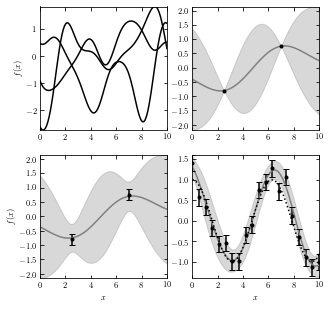

In [9]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.optimize import fmin_cobyla


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2  / h ** 2)

# Draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)
h = 1.0

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

# Constraint the mean and covariance with tow points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
kernel1 = kernels.RBF(1/0.5, (1/0.5, 1/0.5))
gp1 = GaussianProcessRegressor(kernel=kernel1, random_state=0, normalize_y = True)
gp1.fit(x1[:, None], y1)
f1, f1_err = gp1.predict(x[:, None], return_std = True)

# constraint the mean and covariance with two noisy points
dy2 = 0.2
kernel2 = kernels.RBF(1/0.5, (1/0.5, 1/0.5))
gp2 = GaussianProcessRegressor(kernel=kernel2,
                              alpha = (dy2/ y1) ** 2, random_state = 0)
gp2.fit(x1[:, None], y1)
f2, f2_err = gp2.predict(x[:, None], return_std = True)

# Constraint the mean and covarinace with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)

kernel3 = kernels.RBF(0.5, (0.01, 10.0))
gp3 = GaussianProcessRegressor(kernel = kernel3,
                              alpha=(dy3 / y3) ** 2, random_state = 0)
gp3.fit(x3[:, None], y3)
f3, f3_err = gp3.predict(x[:, None], return_std = True)

# We have fit for the 'h' parameter: print the result here:
print('best-fit theta = ', gp3.kernel_.theta[0])

# Plot the diagrams
fig = plt.figure(figsize=(5, 5))


# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)


# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(x, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

### Cosmology Regression Example

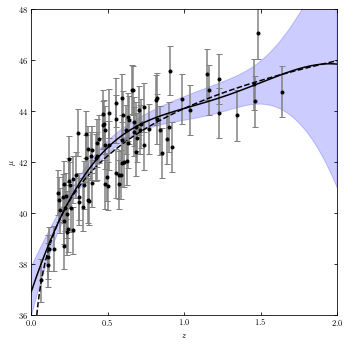

In [12]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from astropy.cosmology import LambdaCDM

from astroML.datasets import generate_mu_z


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


# Generate Data
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0= 0.73, Tcmb0=0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state = 0, cosmo = cosmo)

z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

# fit the data
z_fit = np.linspace(0, 2, 1000)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)
y_pred, sigma = gp.predict(z_fit[:, None], return_std=True)

# Plot the gaussian process
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(111)

ax.plot(z, mu_true, '--k')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', markersize=6)
ax.plot(z_fit, y_pred, '-k')
ax.fill_between(z_fit, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                alpha=0.2, color='b', label='95% confidence interval')

ax.set_xlabel('$z$')
ax.set_ylabel(r'$\mu$')

ax.set_xlim(0, 2)
ax.set_ylim(36, 48)

plt.show()

### Cross Validation Examples: Part 1

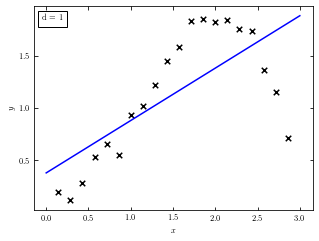

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

# select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

# First figure: plot points with a linear fit
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.scatter(x, y, marker='x', c='k', s=30)

p = np.polyfit(x, y, 1)
y_fit = np.polyval(p, x_fit)

ax.text(0.03, 0.96, "d = 1", transform=plt.gca().transAxes,
        ha='left', va='top',
        bbox=dict(ec='k', fc='w'))

ax.plot(x_fit, y_fit, '-b')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

### Cross Validation Examples: Part 2

/home/lokesh/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


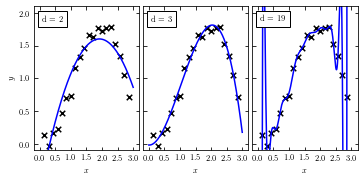

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

# select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

# Secondf figure: plot fit for several order of polynomial
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, d in enumerate([2, 3, 19]):
    ax = fig.add_subplot(131 + i)
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d)
    y_fit = np.polyval(p, x_fit)

    ax.plot(x_fit, y_fit, '-b')
    ax.set_ylim(-0.1, 2.1)
    ax.set_xlim(-0.2, 3.2)
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w'))

plt.show()

### Cross Validation Examples: Part 3

/home/lokesh/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/lokesh/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/lokesh/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


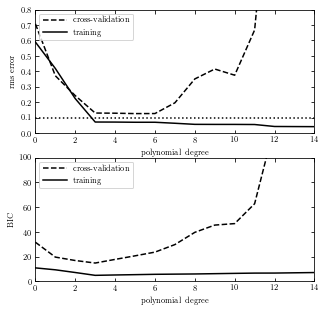

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

# Select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)
x_fit = np.linspace(0, 3, 1000)

# Third figure: plot errors as a function of polynomial defree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig = plt.figure(figsize=(5, 5))
for i in range(len(d)):
    p = np.polyfit(x, y, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x) - y) ** 2)
                             /len(y))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv)**2)
                             /len(y_cv))
    
BIC_train = np.sqrt(len(y) * training_err / dy + d * np.log(len(y)))
BIC_crossval = np.sqrt(len(y)) * crossval_err / dy + d * np.log(len(y))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, 0.1 * np.ones(d.shape), ':k')

ax.set_xlim(0, 14)
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

ax = fig.add_subplot(212)
ax.plot(d, BIC_crossval, '--k', label='cross-validation')
ax.plot(d, BIC_train, '-k', label='training')

ax.set_xlim(0, 14)
ax.set_ylim(0, 100)

ax.legend(loc=2)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')

plt.show()


### Cross Validation Examples : Part 4

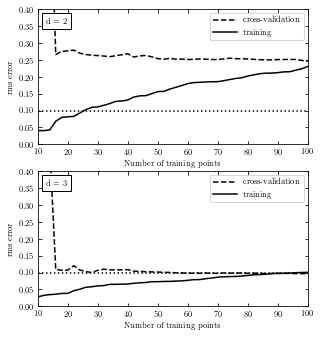

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

# Select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)
x_fit = np.linspace(0, 3, 1000)

# Fourth figure: plot erros as a functio nof training set size
np.random.seed(0)
x = 3 * np.random.random(100)
y = func(x)

np.random.seed(1)
x_cv = 3 * np.random.random(100)
y_cv = func(x_cv)

Nrange = np.arange(10, 101, 2)

fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.15, top = 0.95)

for subplot, d in zip([211, 212], [2, 3]):
    ax = fig.add_subplot(subplot)
    training_err = np.zeros(Nrange.shape)
    crossval_err = np.zeros(Nrange.shape)
    
    for j, N in enumerate(Nrange):
        p = np.polyfit(x[:N], y[:N], d)
        training_err[j] = np.sqrt(np.sum((np.polyval(p, x[:N])
                                        - y[:N]) ** 2) / len(y))
        crossval_err[j] = np.sqrt(np.sum((np.polyval(p, x_cv)
                                        - y_cv) ** 2) / len(y_cv))
    ax.plot(Nrange, crossval_err, '--k', label='cross-validation')
    ax.plot(Nrange, training_err, '-k', label='training')
    ax.plot(Nrange, 0.1 * np.ones(Nrange.shape), ':k')
    ax.legend(loc=1)
    ax.text(0.03, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='k', fc='w'))

    ax.set_ylim(0, 0.4)

    ax.set_xlabel('Number of training points')
    ax.set_ylabel('rms error')

plt.show()